In [123]:
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
from scipy.stats import chi2
from matplotlib import pyplot as plt

In every bin, each data point is treated as sample of normal distribution $N(0,\sigma)$, so this is a interval estimation problem. The point estimation of $\sigma^2$ is
$$\frac{\sum_1^n x_i^2}{n}$$
In essence, this point estimation can be seen as emperical semivariogram since semivariogram is defined as
$$E(f(x)-f(x-r))^2$$
The confidence lower-bound is
$$\frac{\sum_1^n x_i^2}{\chi_n^2(1-\alpha)}$$
where $x$ is the sample, $1-\alpha$ is the confidence level.
If the confidence lower-bound is larger than $(3(1+L^{1/2}))^2$, we can say we have at least $1-\alpha$'s confidence to say the real $\sigma$ is larger than the $(3(1+L^{1/2}))^2$.
https://faculty.elgin.edu/dkernler/statistics/ch09/9-3.html is a reference of the statistics method used here.

This lower-bound can be also understanded in the hypothetical test's manner.
We define null hypotheis as $\sigma^2 <= \sigma_0^2 $. $\sigma_0^2$ is the value by the requirement curve. We will reject this null hypotheis if the samples show this hypotheis is wrong with great confidence.

The test is defined as: If $\sum_1^n x_i^2 > C$, we reject the null hypothesis.

By statistical analysis, if we define $C = \chi_n^2(1-\alpha)\sigma_0^2$, the significance level is equal to $1-\alpha$.

The critria is:
1. If less than `mratio` percent of bins fail to reject the hypotheis and
2. The mean of relative deviation $$(\frac{\sum_1^n x_i^2}{\chi_n^2(1-\alpha)}-\sigma_0^2)/\sigma_0^2$$ in each failed bins less than `mdev`,
we can say this interferogram pass the test.

In [ ]:
# Set Parameters
n_bins = 10 # number of bins
mratio = 0.3
mdev = 0.3

In [124]:
calval_dir = Path.cwd()/'calval'
calval_location = 'central_valley'
work_dir = calval_dir/calval_location

In [125]:
with open(work_dir/'approach2.pkl','rb') as f:
    dist,rel_measure, ifgs_date = pickle.load(f)

In [126]:
n_ifgs = len(dist)

In [127]:
bins = np.linspace(0.1,50.0,num=n_bins+1)
bins_interval = bins[1:] - bins[:-1]
bins_center = bins[:-1]+bins_interval/2

In [128]:
alpha = 0.05

In [129]:
n_all = np.empty([n_ifgs,n_bins+1],dtype=int) # number of points for each ifgs and bins
lowbound = np.empty([n_ifgs,n_bins])
est = np.empty([n_ifgs,n_bins])
rqmt = (3*(1+np.sqrt(bins_center)))**2 # square of the curve
for i in range(n_ifgs):
    inds = np.digitize(dist[i],bins)
    for j in range(1,n_bins+1):
        rem = rel_measure[i][inds==j] # relative measurement for each bin
        len_rem = len(rem)
        n_all[i,j-1] = len_rem
        lowbound[i,j-1] = sum(rem**2)/chi2.ppf(1-alpha,df=len_rem)
        est[i,j-1] = sum(rem**2)/len_rem
        
    n_all[i,-1] = np.sum(n_all[i,0:-2])

In [130]:
def to_str(x:bool):
    if x==True:
        return 'true '
    elif x==False:
        return 'false '

<ipython-input-131-a86890c942ea>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=[18, 5.5])


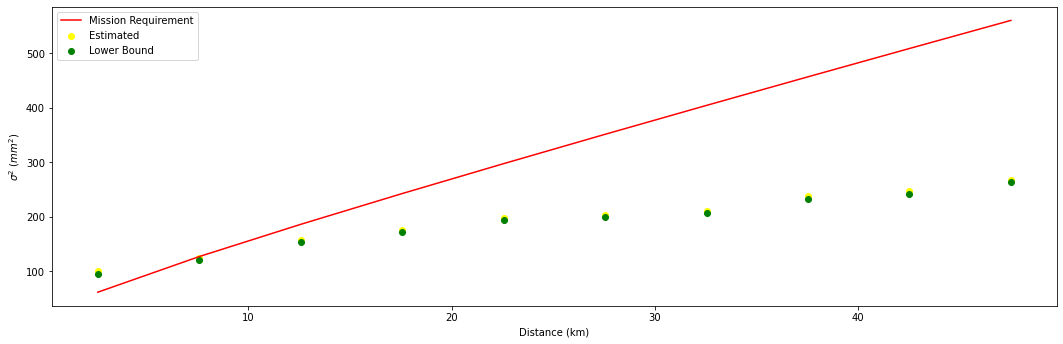

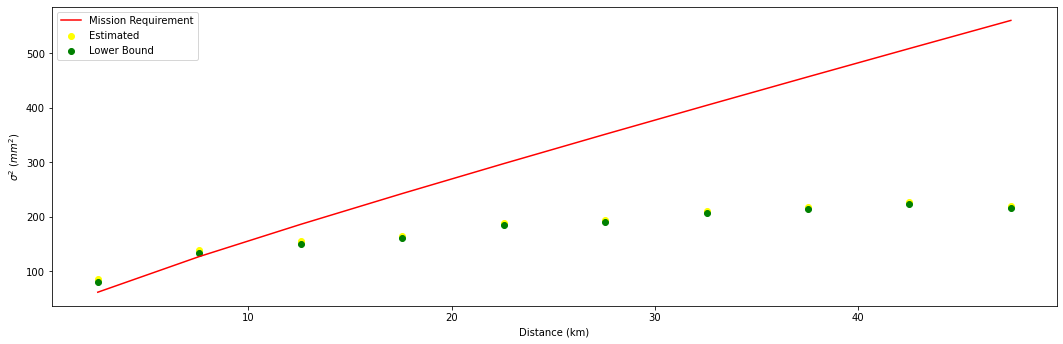

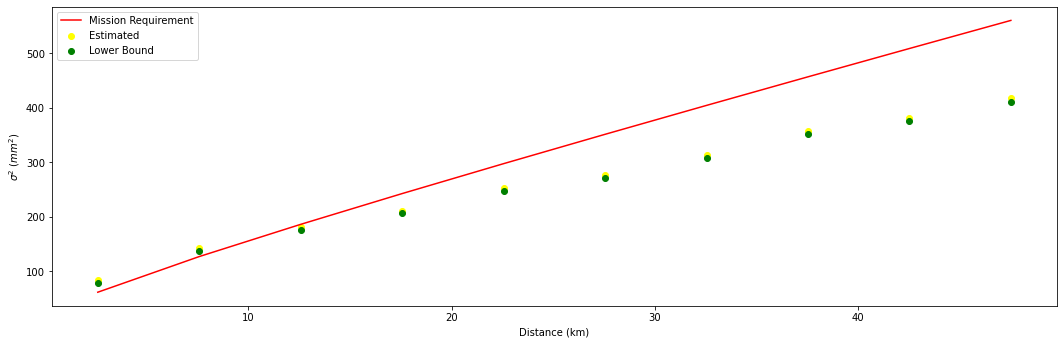

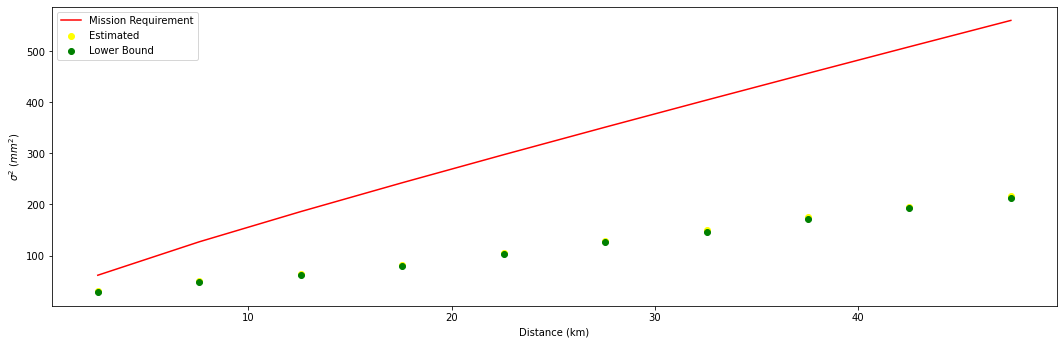

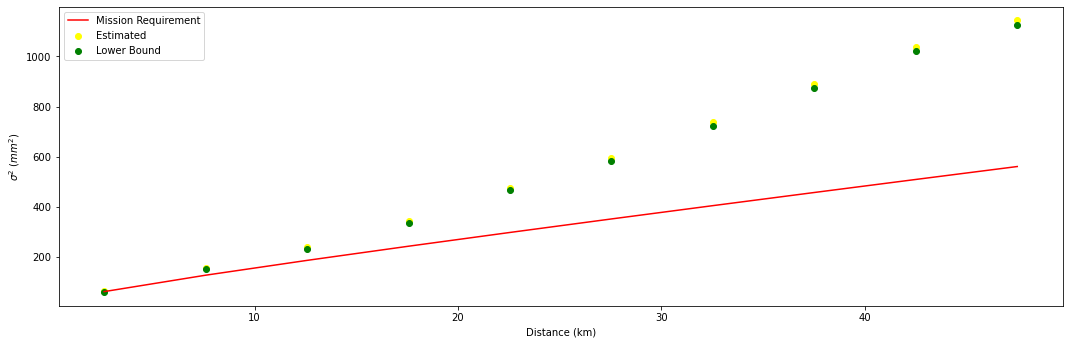

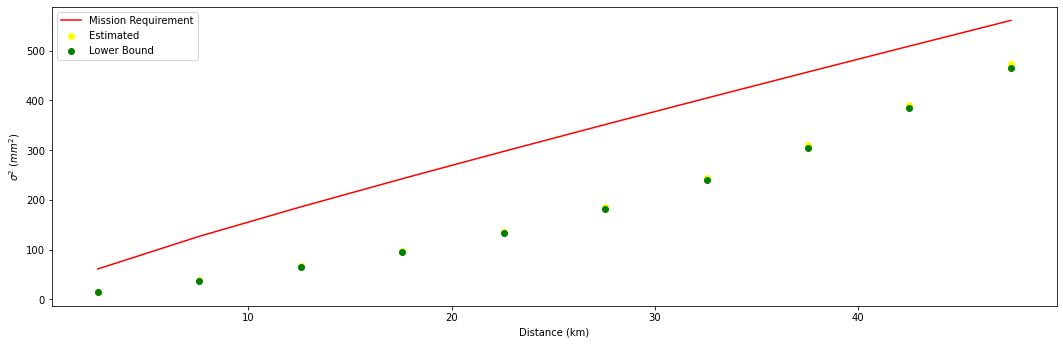

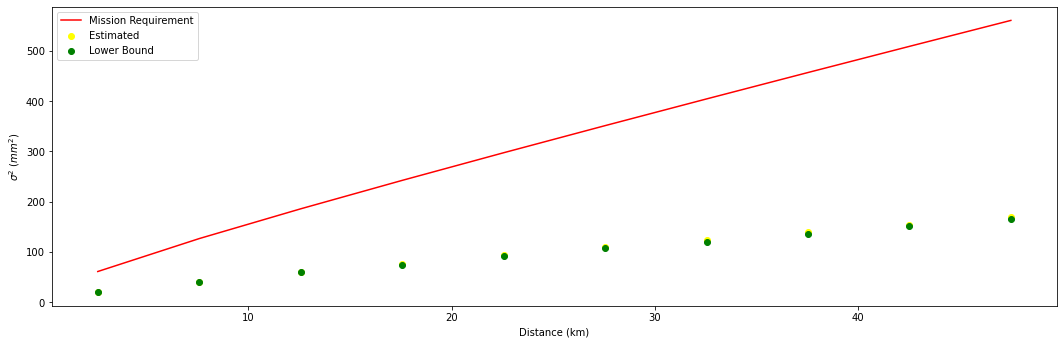

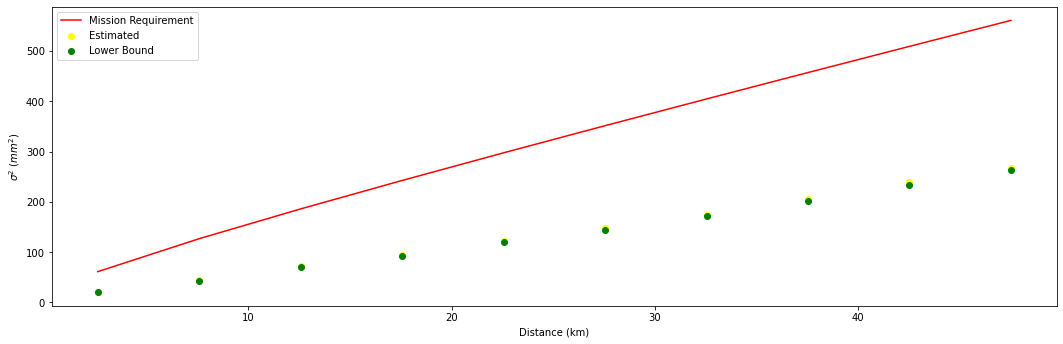

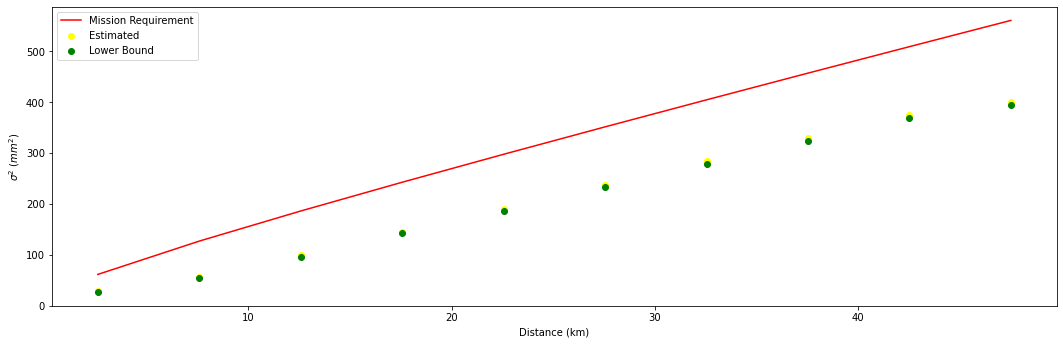

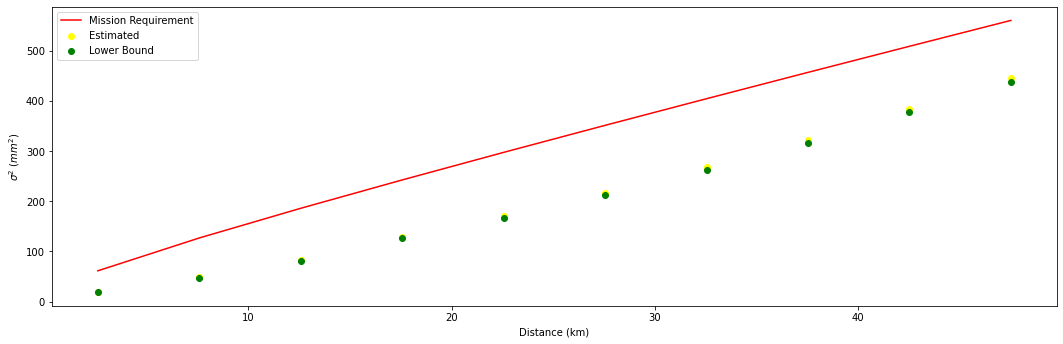

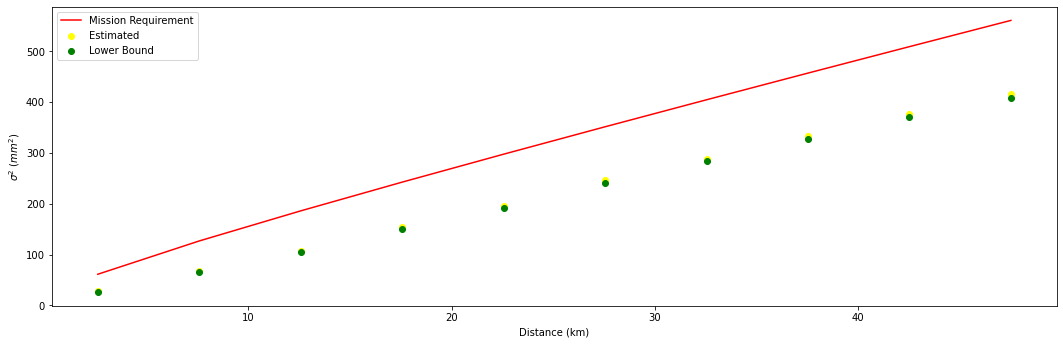

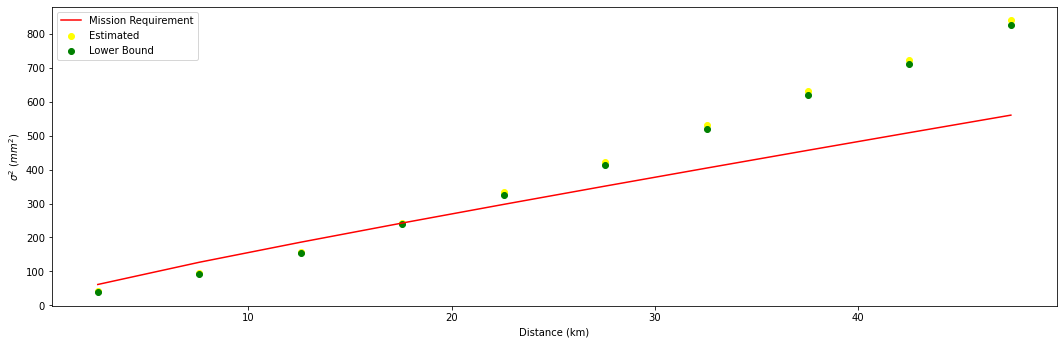

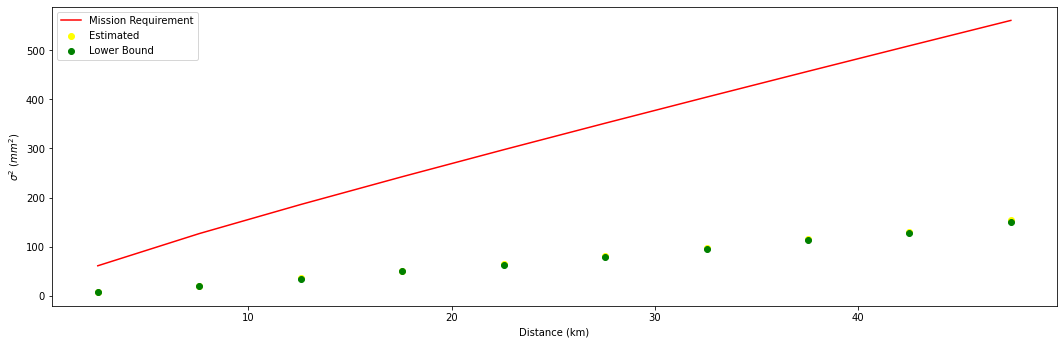

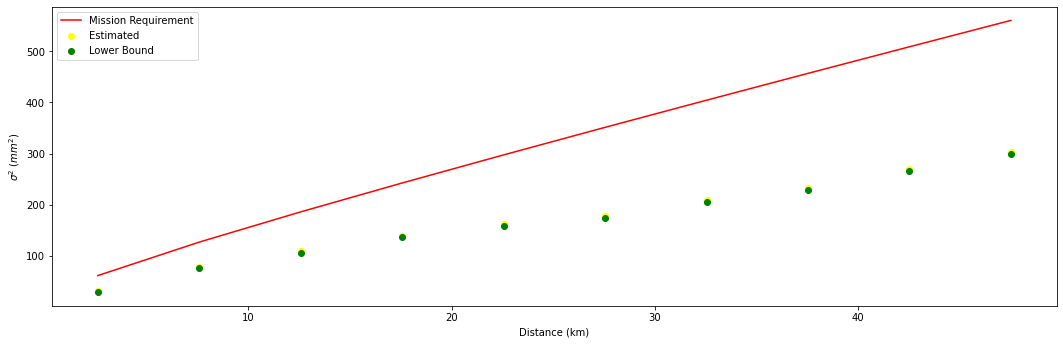

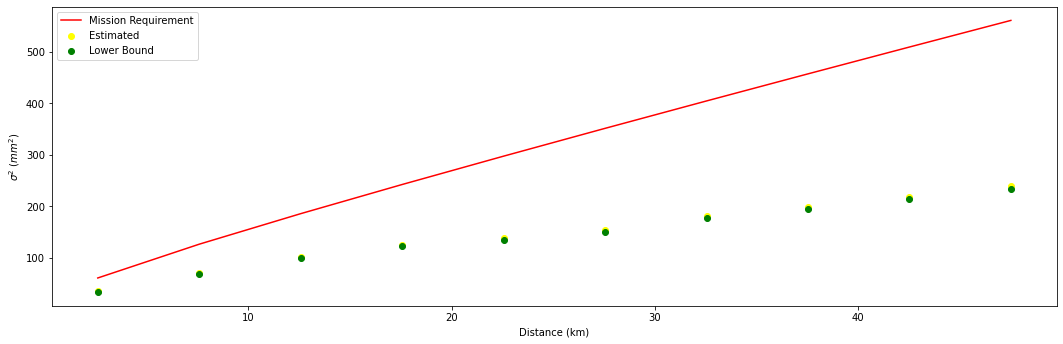

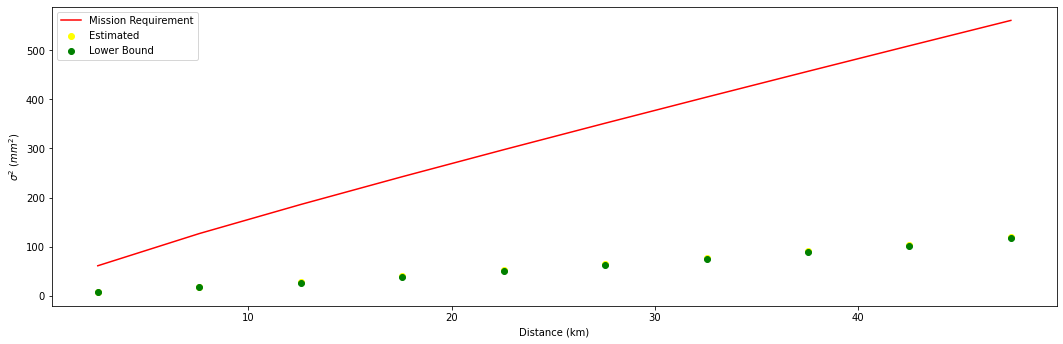

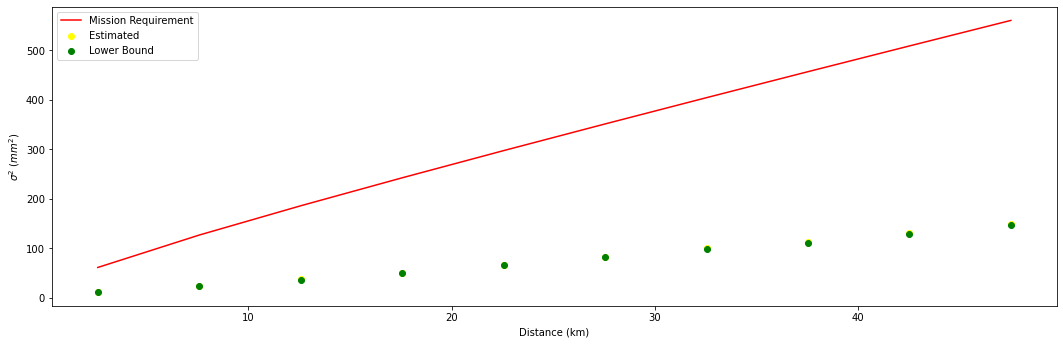

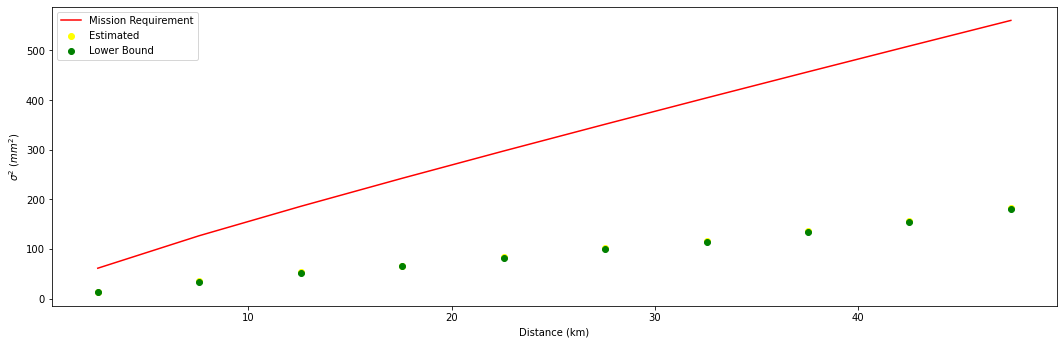

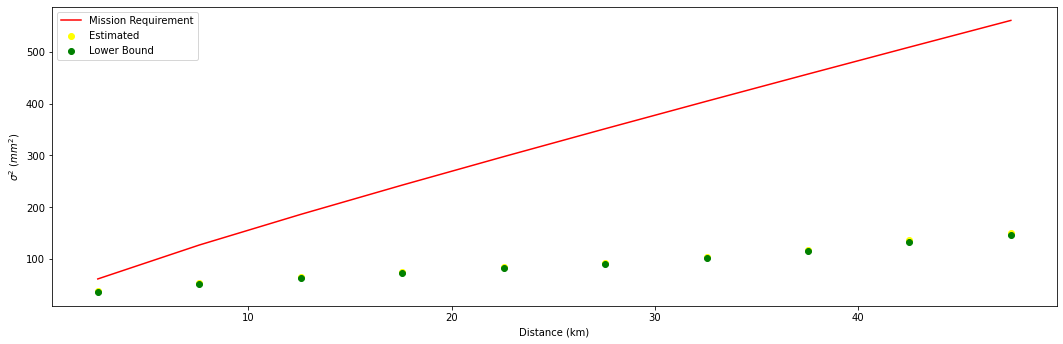

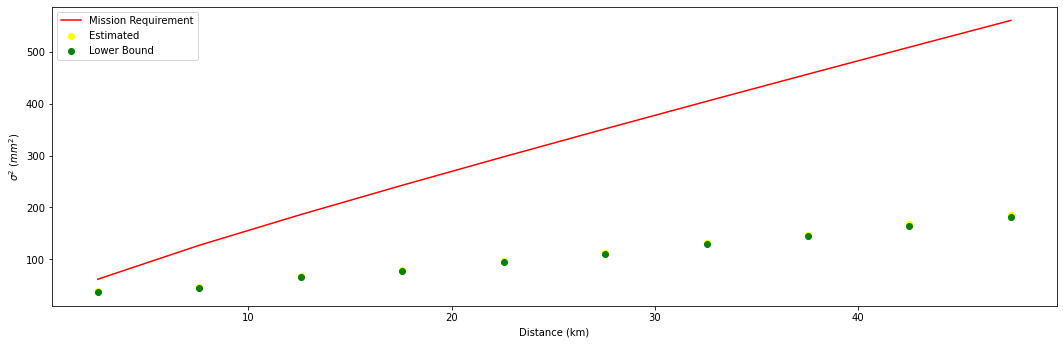

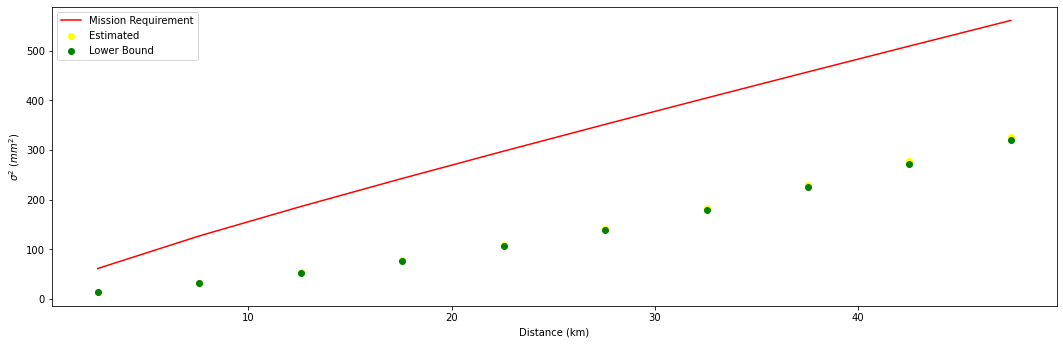

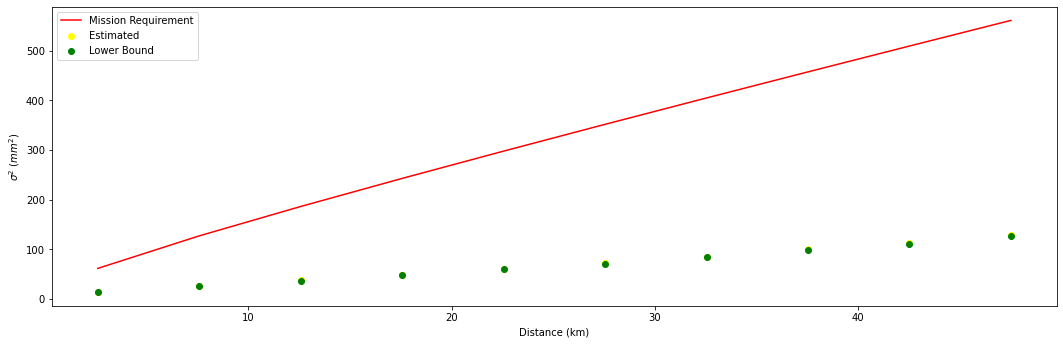

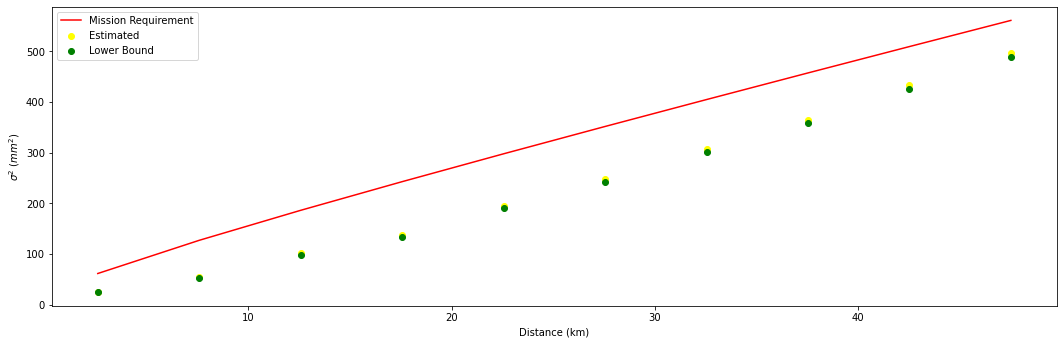

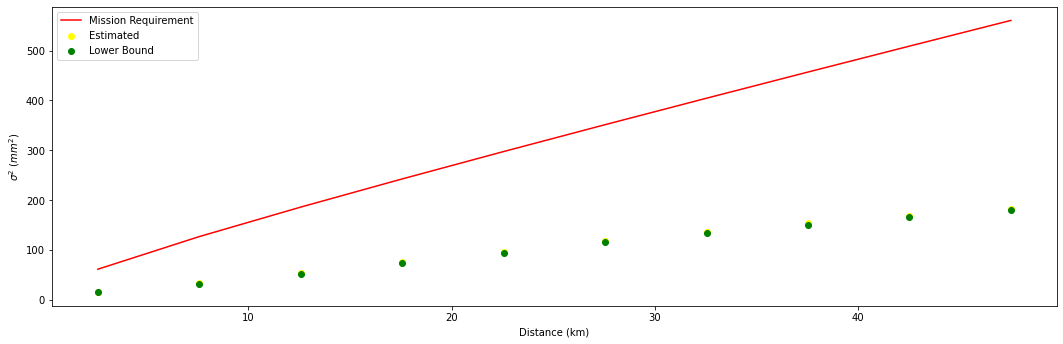

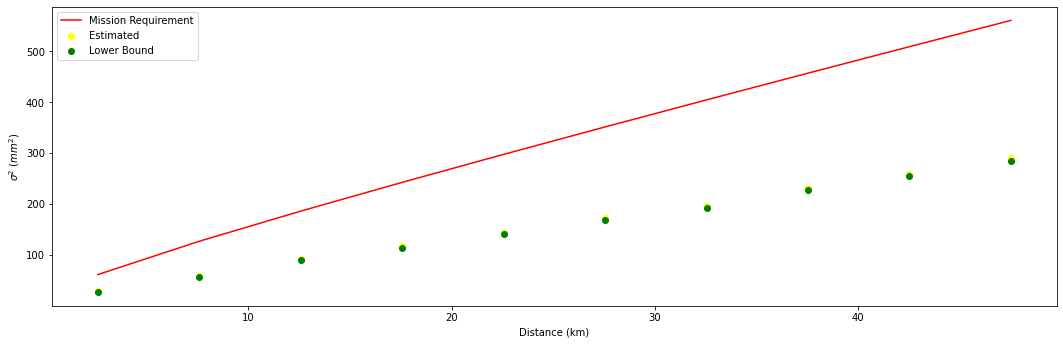

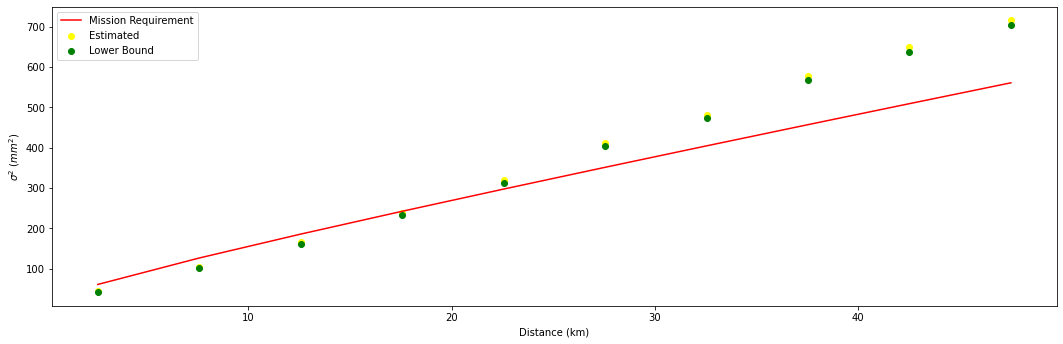

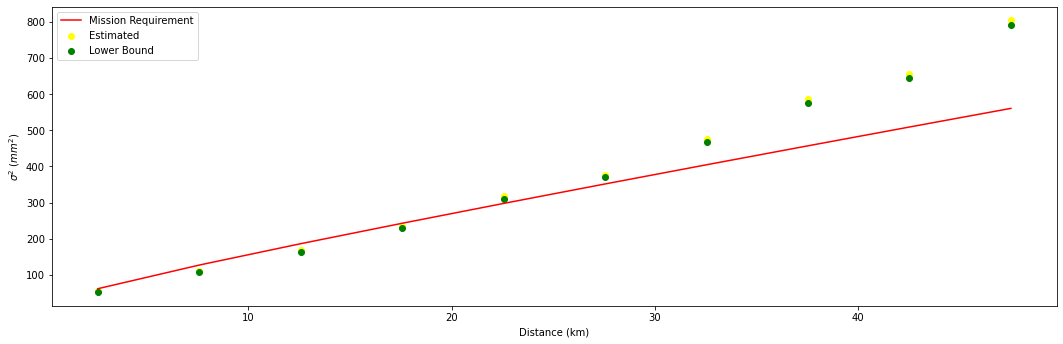

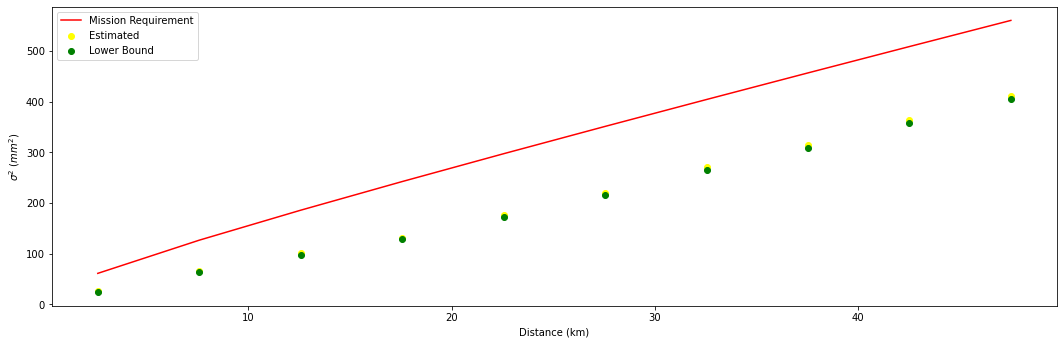

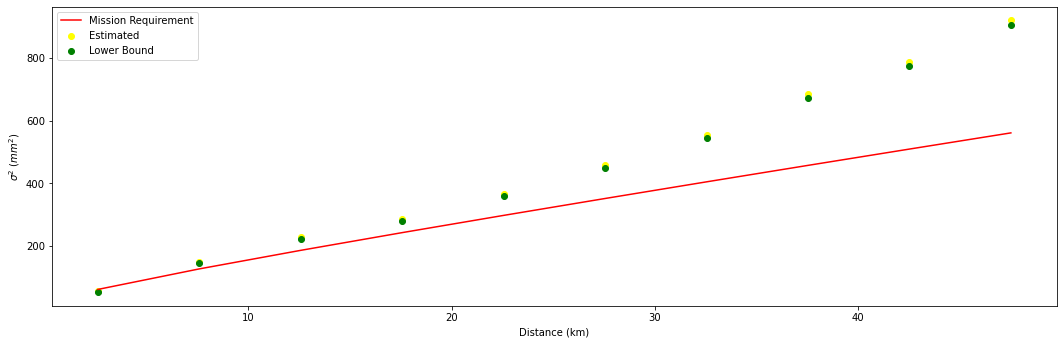

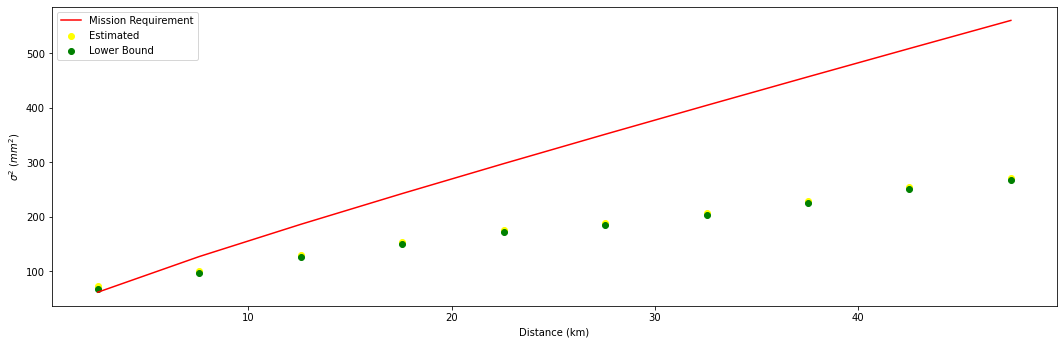

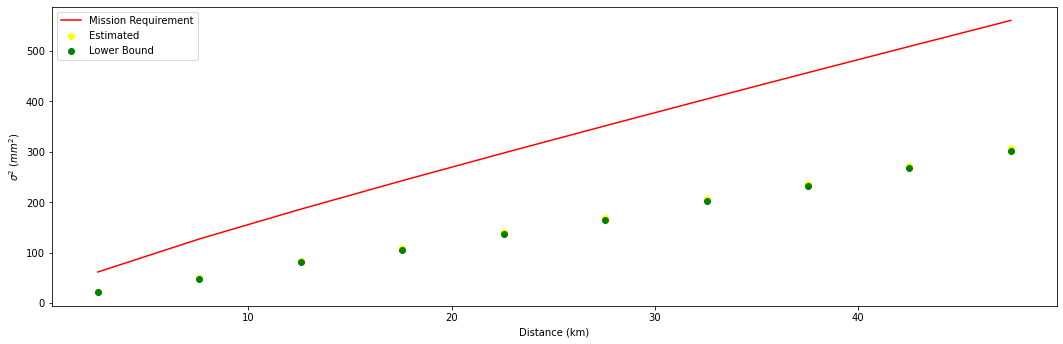

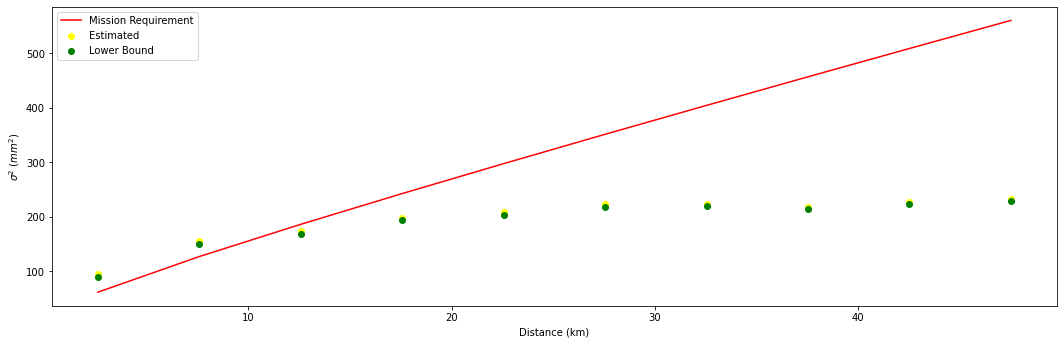

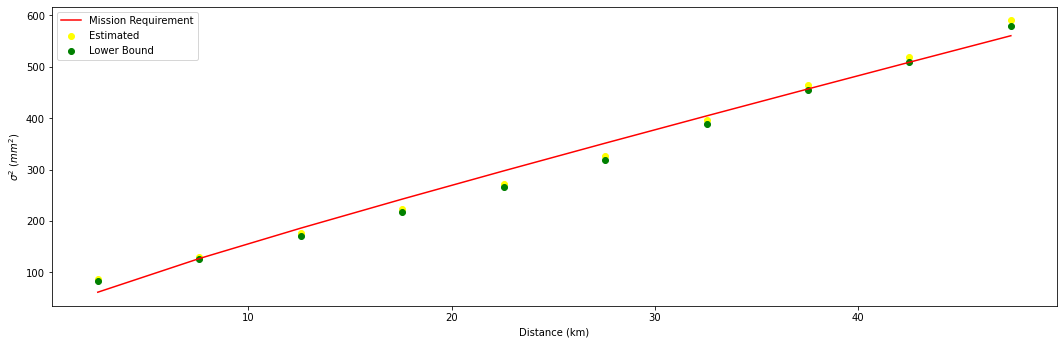

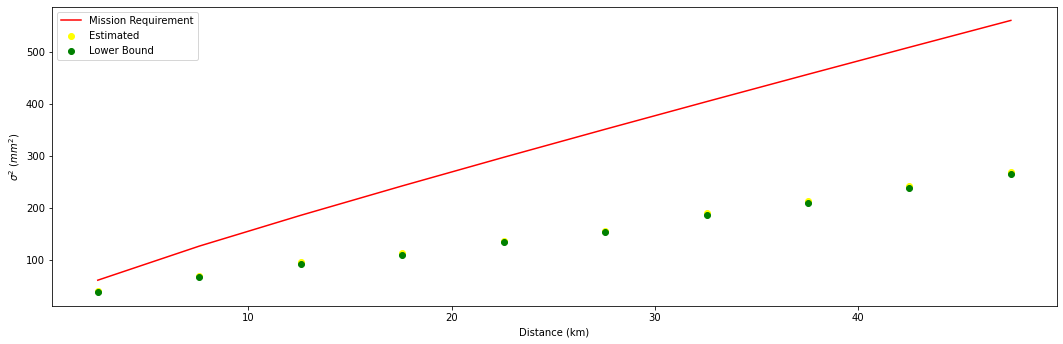

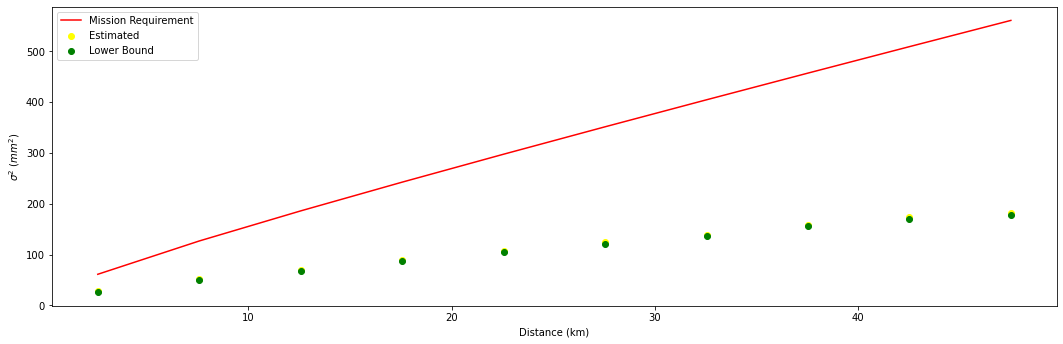

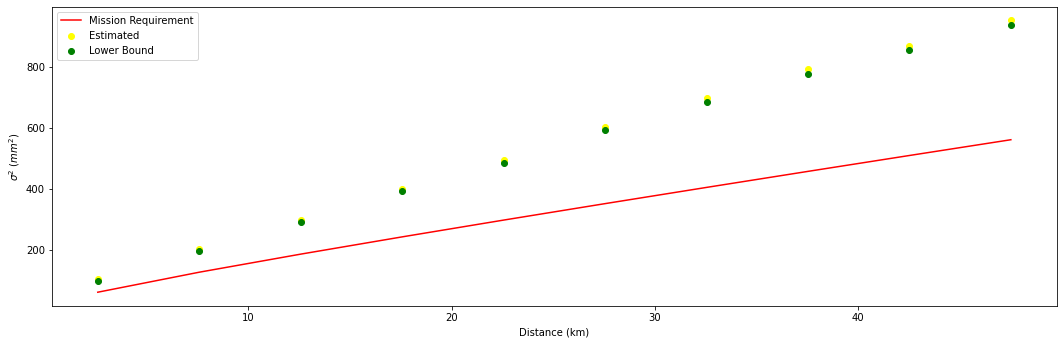

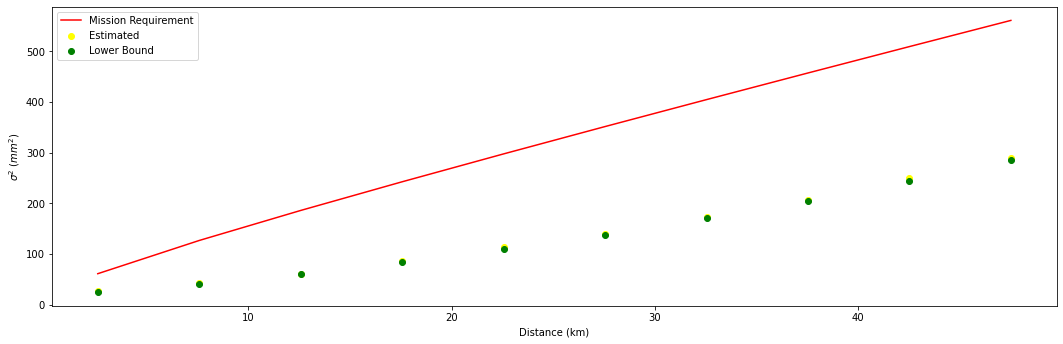

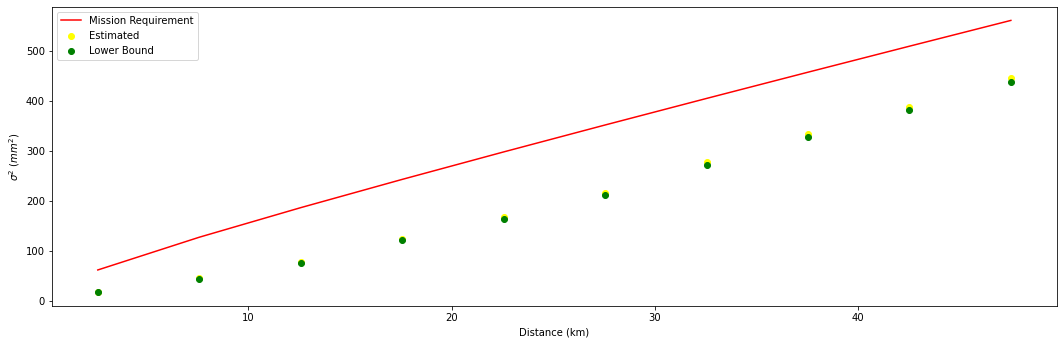

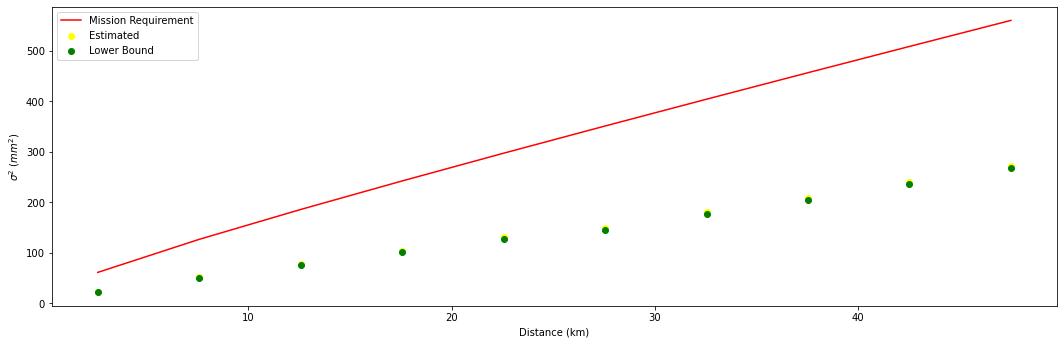

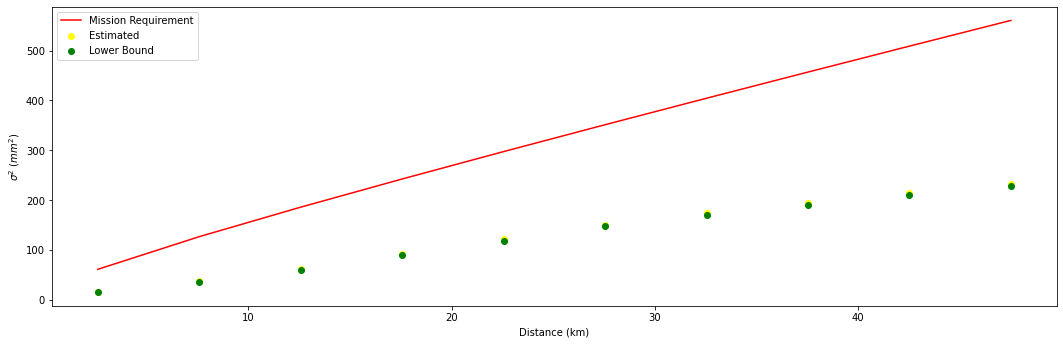

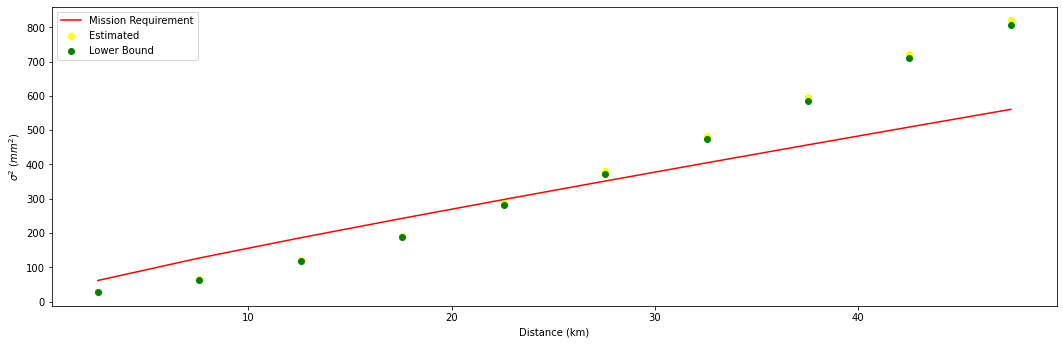

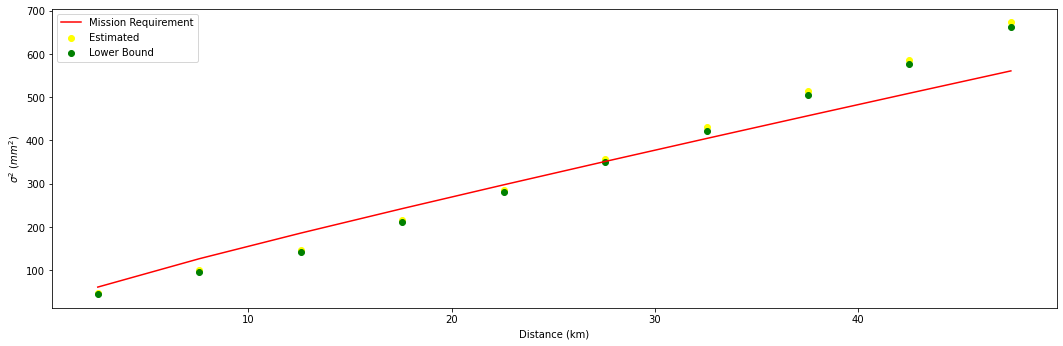

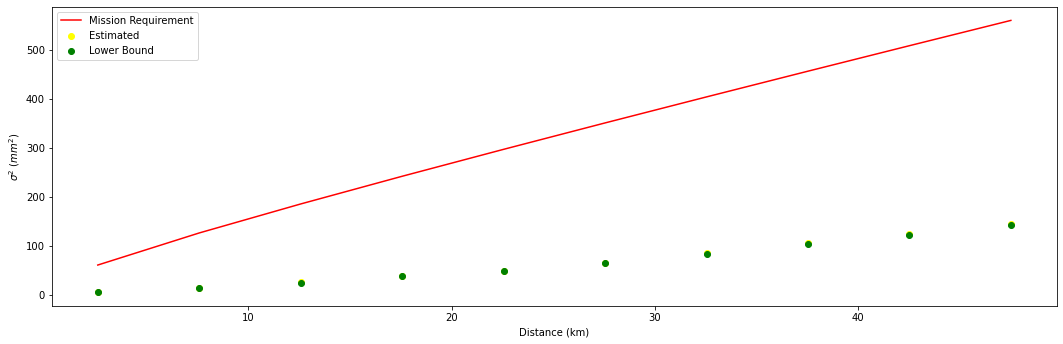

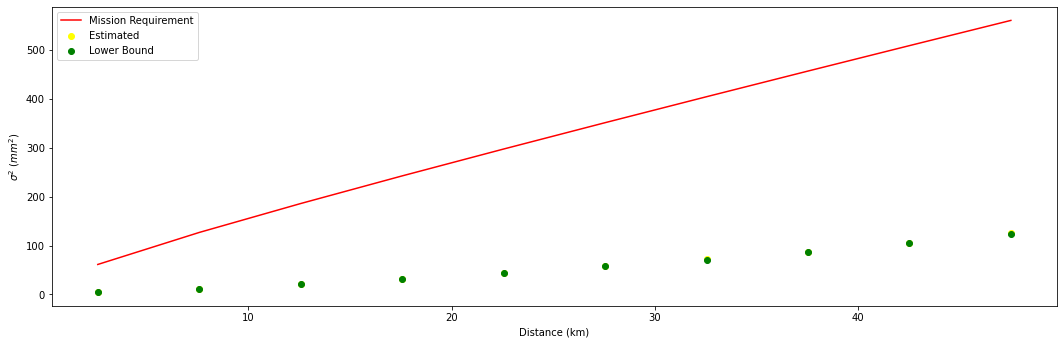

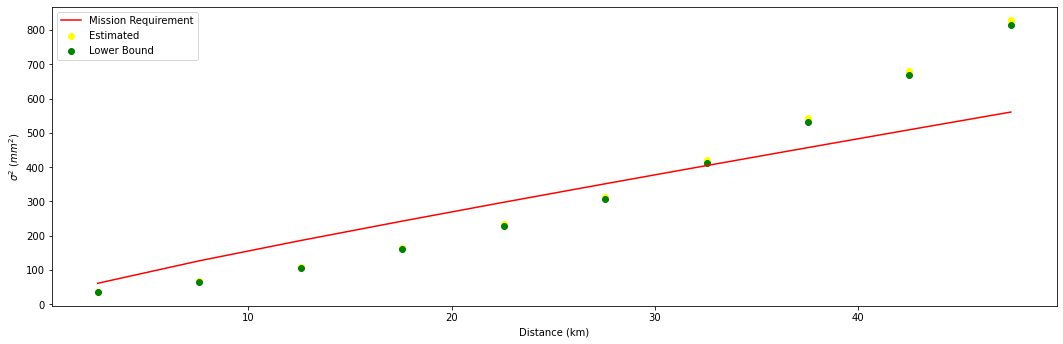

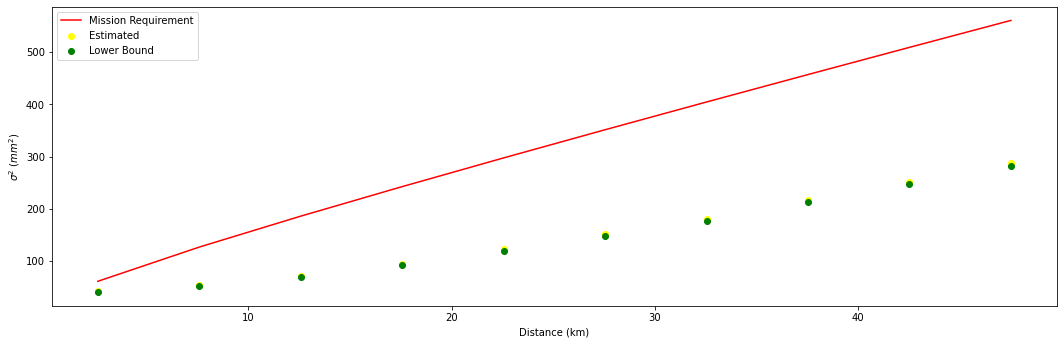

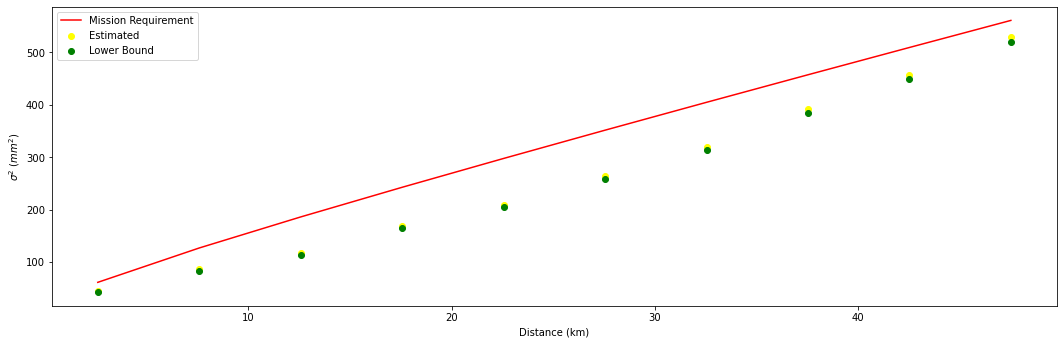

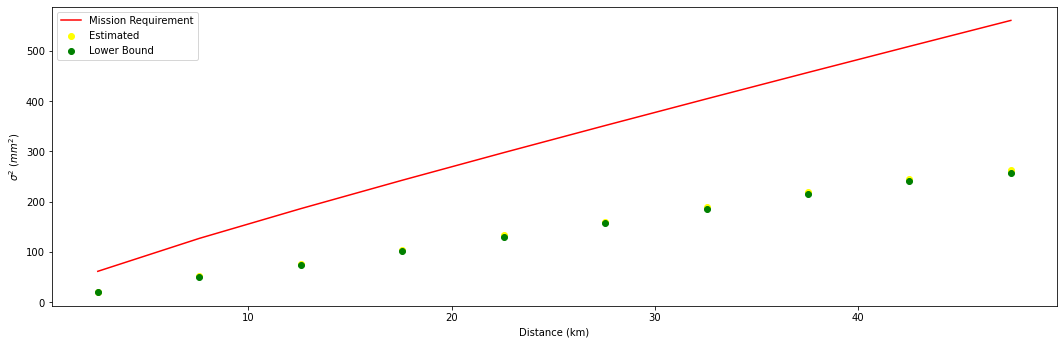

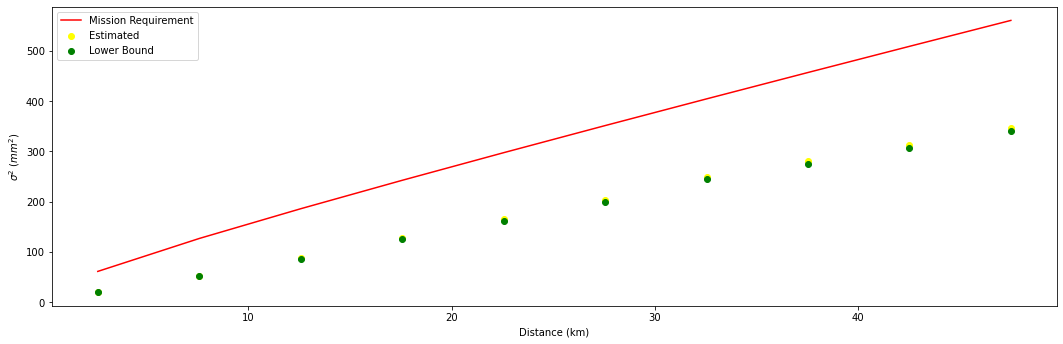

In [131]:
for i in range(n_ifgs):
    fig, ax = plt.subplots(figsize=[18, 5.5])
    ax.plot(bins_center,rqmt,'r')
    ax.scatter(bins_center,est[i],c='yellow')
    ax.scatter(bins_center,lowbound[i],c='green')

    ax.set_xlabel('Distance (km)')
    ax.set_ylabel(r'$\sigma^2$ ($mm^2$)')
    plt.legend(["Mission Requirement","Estimated","Lower Bound"])

In [132]:
dev = (lowbound-rqmt)/rqmt
success_or_fail = dev < 0.0

In [133]:
n_pos = np.empty(n_ifgs)
mean_dev = np.empty(n_ifgs)
success_or_fail_total = np.empty(n_ifgs,dtype=bool)
for i in range(n_ifgs):
    dev_i = dev[i]
    dev_i_pos = dev_i[dev_i>=0.0]
    n_pos[i] = len(dev_i_pos)
    if n_pos[i] == 0:
        mean_dev[i] = 0.0
    else:
        mean_dev[i] = dev_i_pos.mean()
    if n_pos[i]<n_bins*mratio and mean_dev[i] < mdev:
        success_or_fail_total[i] = True
    else:
        success_or_fail_total[i] = False

In [134]:
success_or_fail_total_2d = np.array([success_or_fail_total])
mean_dev = np.array([mean_dev])
success_or_fail = np.hstack((success_or_fail,success_or_fail_total_2d.T))
dev = np.hstack((dev,mean_dev.T))
success_or_fail_str = [list(map(to_str, x)) for x in success_or_fail]

In [135]:
columns = []
for i in range(n_bins):
    columns.append(f'{bins[i]:.2f}-{bins[i+1]:.2f}')
columns.append('mean')

In [136]:
index = []
for i in range(len(ifgs_date)):
    index.append(ifgs_date[i,0].strftime('%Y%m%d')+'-'+ifgs_date[i,1].strftime('%Y%m%d'))

In [137]:
dev_pd = pd.DataFrame(dev,columns=columns,index=index)
success_or_fail_pd = pd.DataFrame(success_or_fail_str,columns=columns,index=index)

In [138]:
s = dev_pd.style
s.set_table_styles([  # create internal CSS classes
    {'selector': '.true', 'props': 'background-color: #e6ffe6;'},
    {'selector': '.false', 'props': 'background-color: #ffe6e6;'},
], overwrite=False)
s.set_td_classes(success_or_fail_pd)

,0.10-5.09,5.09-10.08,10.08-15.07,15.07-20.06,20.06-25.05,25.05-30.04,30.04-35.03,35.03-40.02,40.02-45.01,45.01-50.00,mean
20170108-20170120,0.544714,-0.049475,-0.176359,-0.293408,-0.346916,-0.432863,-0.487784,-0.490234,-0.523516,-0.530429,0.544714
20170114-20170126,0.311475,0.058144,-0.189201,-0.339804,-0.379670,-0.458440,-0.490205,-0.532861,-0.561615,-0.613436,0.184809
20170120-20170201,0.285364,0.081093,-0.053876,-0.150546,-0.167291,-0.230286,-0.238562,-0.231428,-0.262555,-0.266668,0.183228
20170225-20170309,-0.542034,-0.624027,-0.663833,-0.672720,-0.656207,-0.638955,-0.637115,-0.624660,-0.622167,-0.620284,0.000000
20170321-20170402,-0.039075,0.191236,0.242415,0.383691,0.567273,0.658002,0.789021,0.910977,1.004027,1.005887,0.639170
20170414-20170426,-0.761409,-0.708639,-0.651112,-0.610339,-0.552211,-0.482599,-0.407633,-0.334283,-0.245164,-0.168833,0.000000
20170508-20170520,-0.670577,-0.688306,-0.679024,-0.694682,-0.689583,-0.694785,-0.700930,-0.700907,-0.701681,-0.702760,0.000000
20170601-20170613,-0.666817,-0.666405,-0.621507,-0.616816,-0.598990,-0.588274,-0.577332,-0.556750,-0.539345,-0.530039,0.000000
20170625-20170707,-0.569466,-0.573333,-0.482473,-0.414745,-0.374830,-0.335723,-0.312374,-0.290379,-0.275653,-0.297529,0.000000
20170719-20170731,-0.694847,-0.622928,-0.568538,-0.480473,-0.437816,-0.396685,-0.349151,-0.307894,-0.259030,-0.219620,0.000000


Percentage of interferograms passes the requirement (significant level = 0.95):

In [139]:
np.count_nonzero(success_or_fail_total)/len(success_or_fail_total)

0.7551020408163265